# Fine-tune BLIP using Hugging Face `transformers` and `datasets` 🤗

<!-- This tutorial is largely based from the [GiT tutorial](https://colab.research.google.com/drive/1HLxgrG7xZJ9FvXckNG61J72FkyrbqKAA?usp=sharing) on how to fine-tune GiT on a custom image captioning dataset. Here we will use a dummy dataset of [football players](https://huggingface.co/datasets/ybelkada/football-dataset) ⚽ that is uploaded on the Hub. The images have been manually selected together with the captions. -->
本教程主要基于 [GiT 教程](https://colab.research.google.com/drive/1HLxgrG7xZJ9FvXckNG61J72FkyrbqKAA?usp=sharing), 介绍如何在自定义图像字幕数据集上微调 GiT。在这里, 我们将使用上传到 Hub 的 [足球运动员](https://huggingface.co/datasets/ybelkada/football-dataset) 虚拟数据集。图像和字幕都是手动选择的。

<!-- Check the 🤗 [documentation](https://huggingface.co/docs/datasets/image_dataset) on how to create and upload your own image-text dataset. -->
查看[文档](https://huggingface.co/docs/datasets/image_dataset)以了解如何创建和上传您自己的图像文本数据集。

## Set-up environment

In [ ]:
#!pip install git+https://github.com/huggingface/transformers.git@main

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/younesbelkada/transformers.git (to revision blip-train-support) to /tmp/pip-req-build-gn4s6x3z
  Running command git clone --filter=blob:none --quiet https://github.com/younesbelkada/transformers.git /tmp/pip-req-build-gn4s6x3z
  Running command git checkout -b blip-train-support --track origin/blip-train-support
  Switched to a new branch 'blip-train-support'
  Branch 'blip-train-support' set up to track remote branch 'blip-train-support' from 'origin'.
  Resolved https://github.com/younesbelkada/transformers.git to commit 27c6b9889d900fb87dfdec225b0d8e7c4fa09937
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [1]:
!pip install -q datasets

## Load the image captioning dataset

<!-- Let's load the image captioning dataset, you just need few lines of code for that. -->
让我们加载图像字幕数据集, 您只需要几行代码。

In [2]:
from datasets import load_dataset 

dataset = load_dataset("ybelkada/football-dataset", split="train")

如果遇到"ValueError: Invalid pattern: '**' can only be an entire path component"问题, 尝试

In [ ]:
!pip install -U datasets fsspec

<!-- Let's retrieve the caption of the first example: -->
让我们取出第一个例子的标题:

In [3]:
dataset[0]["text"]

"Benzema after Real Mardid's win against PSG"

<!-- And the corresponding image -->
其相应的图像

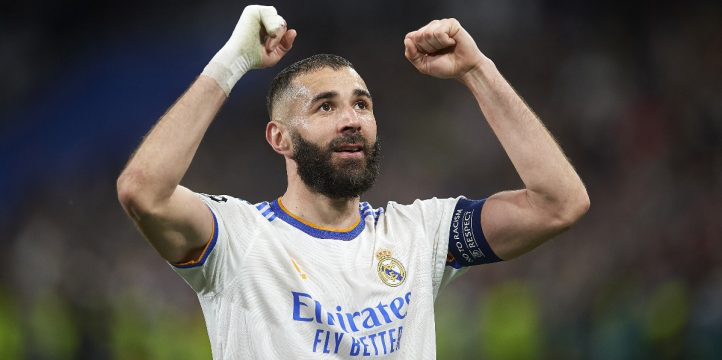

In [4]:
dataset[0]["image"]

## Create PyTorch Dataset

<!-- The lines below are entirely copied from the original notebook! -->
下面的几行全部是从原始笔记本中复制而来的！

In [5]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

## Load model and processor

In [6]:
from transformers import AutoProcessor, BlipForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

/home/qj00182/miniconda3/envs/robohusky/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


<!-- Now that we have loaded the processor, let's load the dataset and the dataloader: -->
现在我们已经加载了 processor, 让我们加载 dataset 和 dataloader:

In [7]:
train_dataset = ImageCaptioningDataset(dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)

In [8]:
train_dataset[0].keys()

dict_keys(['pixel_values', 'input_ids', 'attention_mask'])

## Train the model

<!-- Let's train the model! Run the simply the cell below for training the model -->
让我们训练模型! 运行下面的简单单元来训练模型

In [9]:
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(50):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    # batch.keys() = dict_keys(['pixel_values', 'input_ids', 'attention_mask'])
    input_ids = batch.pop("input_ids").to(device)       # todo: input_ids 是 encoding 吗?
    pixel_values = batch.pop("pixel_values").to(device) # (bitch size, 3, height, weight)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)
    
    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

Epoch: 0


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Loss: 13.08035659790039
Loss: 10.235548973083496
Loss: 10.2218017578125
Epoch: 1
Loss: 10.2098388671875
Loss: 10.169804573059082
Loss: 10.17786693572998
Epoch: 2
Loss: 10.140953063964844
Loss: 10.11743450164795
Loss: 10.152393341064453
Epoch: 3
Loss: 10.103964805603027
Loss: 10.118612289428711
Loss: 10.088308334350586
Epoch: 4
Loss: 10.096921920776367
Loss: 10.064618110656738
Loss: 10.042609214782715
Epoch: 5
Loss: 10.001801490783691
Loss: 10.024828910827637
Loss: 10.03580379486084
Epoch: 6
Loss: 9.932331085205078
Loss: 9.87128734588623
Loss: 9.461926460266113
Epoch: 7
Loss: 9.312756538391113
Loss: 9.041561126708984
Loss: 8.825200080871582
Epoch: 8
Loss: 8.54700756072998
Loss: 8.416854858398438
Loss: 8.190864562988281
Epoch: 9
Loss: 7.983996391296387
Loss: 7.811583042144775
Loss: 7.648218154907227
Epoch: 10
Loss: 7.47083854675293
Loss: 7.308795928955078
Loss: 7.184372901916504
Epoch: 11
Loss: 7.0025177001953125
Loss: 6.877263069152832
Loss: 6.752835273742676
Epoch: 12
Loss: 6.579467773

## Inference

<!-- Let's check the results on our train dataset -->
让我们检查一下训练数据集上的结果

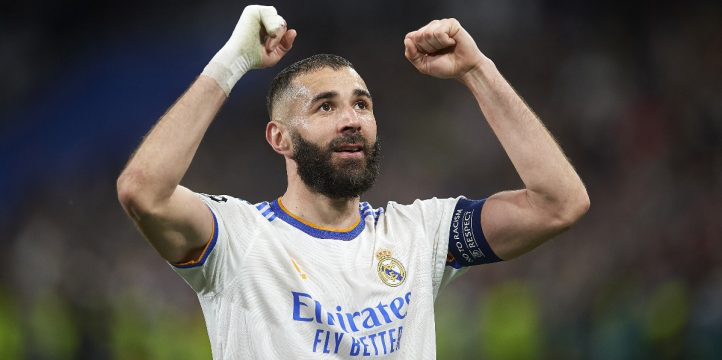

In [10]:
# load image
example = dataset[0]
image = example["image"]
image

In [11]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

benzema after real mardid's win against psg


## Load from the Hub

<!-- Once trained you can push the model and processor on the Hub to use them later. 
Meanwhile you can play with the model that we have fine-tuned! -->
训练完成后, 您可以将 model 和 processor 推送到 Hub 上, 以便稍后使用。
同时, 您可以使用我们微调过的模型!

In [12]:
from transformers import BlipForConditionalGeneration, AutoProcessor

model = BlipForConditionalGeneration.from_pretrained("ybelkada/blip-image-captioning-base-football-finetuned").to(device)
processor = AutoProcessor.from_pretrained("ybelkada/blip-image-captioning-base-football-finetuned")

/home/qj00182/miniconda3/envs/robohusky/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


<!-- Let's check the results on our train dataset! -->
让我们检查一下训练数据集上的结果!

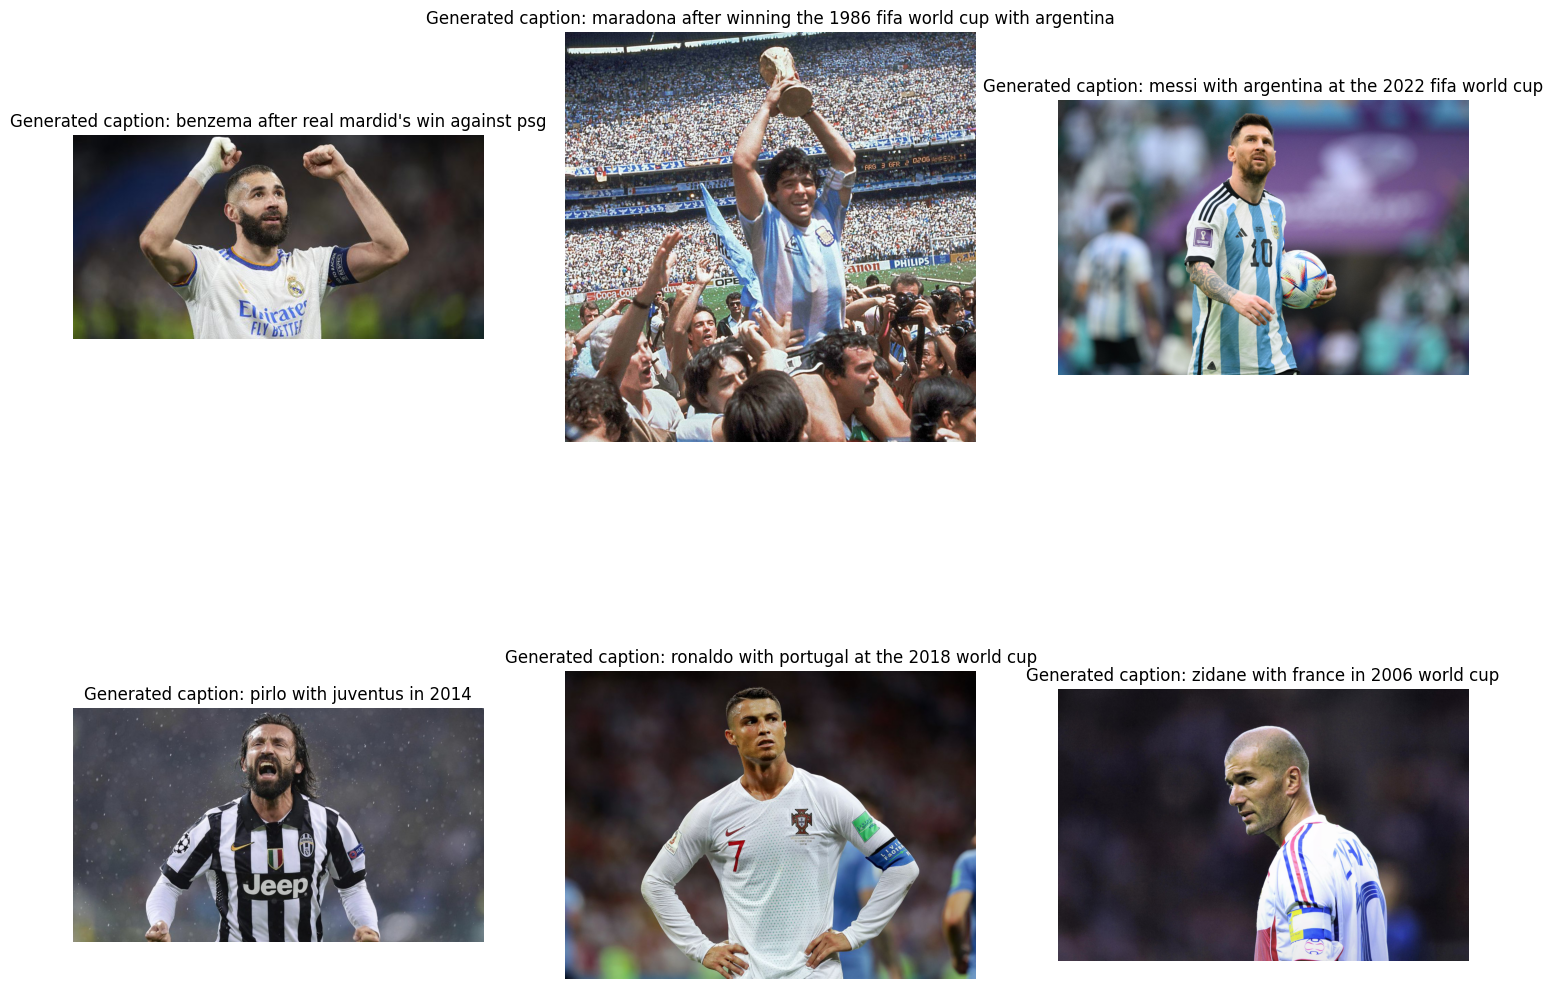

In [13]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(18, 14))

# prepare image for the model
for i, example in enumerate(dataset):
  image = example["image"]
  inputs = processor(images=image, return_tensors="pt").to(device)
  pixel_values = inputs.pixel_values

  generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  fig.add_subplot(2, 3, i+1)
  plt.imshow(image)
  plt.axis("off")
  plt.title(f"Generated caption: {generated_caption}")